<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/problem1.csv')

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Before_null = df.isnull().sum().to_frame()

## 결측치 확인  - Quantity 의 Null
#display(df.isnull().sum())

# C (취소)인 경우와 아닌 경우로 각각의 Unitprice 의 평균으로 대치

# 1. C 가 아닌 경우의 UnitPrice
unit_map = {ids : price for ids, price in
      df[df.InvoiceNo.str[0] != 'C'].groupby('StockCode')['UnitPrice'].mean().reset_index().values }

# 2. C 인 경우의 Qantity

quant_map = {ids : quant  for ids, quant in
            df[df.InvoiceNo.str[0] == 'C'].groupby('StockCode')['Quantity'].mean().reset_index().values }


# 3. C 가 아닌 경우의 Qaunitity

not_c_quant_map = {ids : price for ids, price in
                  df[df.InvoiceNo.str[0] != 'C'].groupby('StockCode')['Quantity'].mean().reset_index().values}


# 4. 결측치 1
## UnitPrice 가 Null 인 곳에 StockCode별로 map 적용
df.loc[df.UnitPrice.isnull(), 'UnitPrice'] = df.loc[df.UnitPrice.isnull()]['StockCode'].map(unit_map)


# Quanitity는 취소와 취소가 아닌것으로 구분
# C 취소인 경우
df.loc[(df.Quantity.isnull()) & (df.InvoiceNo.str[0] == 'C'), 'Quantity'] = \
df.loc[(df.Quantity.isnull()) & (df.InvoiceNo.str[0] == 'C')]['StockCode'].map(quant_map)

# C가 없는 경우

df.loc[(df.Quantity.isnull()) & (df.InvoiceNo.str[0] != 'C'), 'Quantity'] = \
df.loc[(df.Quantity.isnull()) & (df.InvoiceNo.str[0] != 'C')]['StockCode'].map(not_c_quant_map)

After_null = df.isnull().sum().to_frame()

null_table = pd.concat([Before_null , After_null], axis = 1)
null_table.columns = ['Before', 'After']
null_table

,Before,After
InvoiceNo,0,0
StockCode,0,0
Description,0,0
Quantity,25,0
InvoiceDate,0,0
UnitPrice,97,1
CustomerID,0,0
Country,0,0


이상치를 제거하는 방법을 설명하고, 이상치 제거 전 후 결과에 대해 통계적인 방법을 포함하여 설명

In [3]:
# 이상치의 boxplots
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,35801.0,18.423253,-480.0,4.0,10.0,16.0,2400.0,42.148403
InvoiceDate,35801,2011-07-10 02:19:39.900561408,2010-12-01 08:45:00,2011-04-08 09:54:00,2011-08-02 09:14:00,2011-10-12 13:15:00,2011-12-09 12:50:00,NaN
UnitPrice,35800.0,4.607905,0.0,1.25,1.95,3.75,4161.06,48.018465
CustomerID,35801.0,13221.82439,12354.0,12523.0,12681.0,14156.0,17097.0,1012.177727


In [4]:
# 이상치 중 0이 아닌것들만 추출
df_filter = df[df.UnitPrice != 0].reset_index(drop = True)

# Total Price
df_filter['total_price'] =  df_filter['UnitPrice'] * df_filter['Quantity']

각 StockCode을 기준으로 파생변수들을 만들고 제품들의 특성에 따른 군집 생성을 위한 전처리를 수행

In [5]:
## 1) 취소가 아닌것들만 추출

df_buy = df_filter[df_filter['InvoiceNo'].str[0] != 'C'].reset_index(drop = True)


# 2) StockCode 기준 나라의 수
country = df_buy.groupby('StockCode')['Country'].agg(lambda x : list(set(x))).str.len()

# 3) StockCode 별 고객의 수
customer_cnt = df_buy.groupby('StockCode')['CustomerID'].size()

# 4) StockCode별 UnitPrice, Qauntity , Total_price
prices = df_buy.groupby('StockCode')[['UnitPrice','Quantity','total_price']].mean()

df_t = pd.merge(pd.merge(prices, country, left_index = True , right_index = True), customer_cnt, left_index = True, right_index = True)
print(df_t.head(5))

           UnitPrice   Quantity  total_price  Country  CustomerID
StockCode                                                        
10002       0.850000  35.083333    29.820833        5          12
10120       0.210000  10.000000     2.100000        1           1
10125       0.750769  46.923077    37.900000        3          13
10133       0.527500  17.500000     8.425000        3           4
10135       0.910000  90.000000    83.233333        3           3


,UnitPrice,Quantity,total_price,Country,CustomerID
count,2653.000000,2653.000000,2653.000000,2653.000000,2653.000000
mean,-0.018731,-0.014622,-0.011998,0.000205,-0.012576
std,0.314227,0.626546,0.867596,0.999923,0.753300
min,-0.190016,-0.483178,-0.782425,-1.180108,-0.447567
25%,-0.145215,-0.341876,-0.421996,-0.715927,-0.410563
50%,-0.098370,-0.172313,-0.235236,-0.251745,-0.299552
75%,0.016513,0.097194,0.099794,0.676619,0.033480
max,9.009171,9.436223,19.569703,2.069164,9.469403


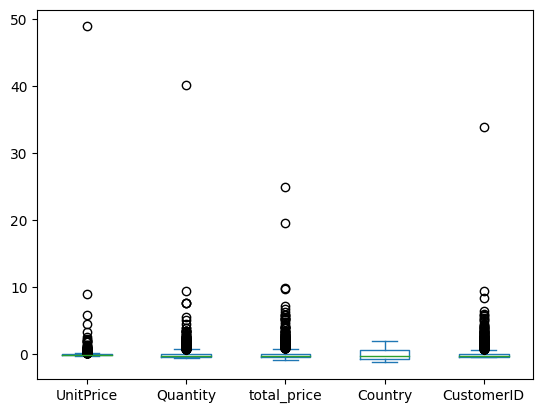

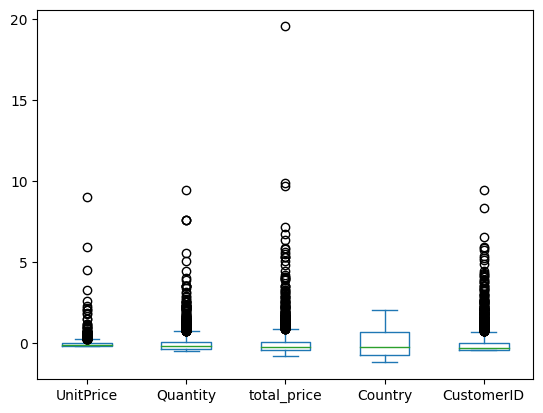

In [57]:
# 군집 처리를 위한 스케일링

ss = StandardScaler()
scaled_df = pd.DataFrame(ss.fit_transform(df_t) , columns = df_t.columns, index = df_t.index)

## Scaled_df box_plot - 이상치 제거 : 20 이상의 수들은 제거한다.
scaled_df.plot(kind = 'box')

# 20 보다 작은 것들 drop na 한다.

below_20 = scaled_df[scaled_df < 20].dropna()
below_20.plot(kind = 'box')

display(below_20.describe())

Kmeans , DBSCAN 방법 중 하나를 선택하여 군집분석을 시행하고 각 군집별 특성을 분석

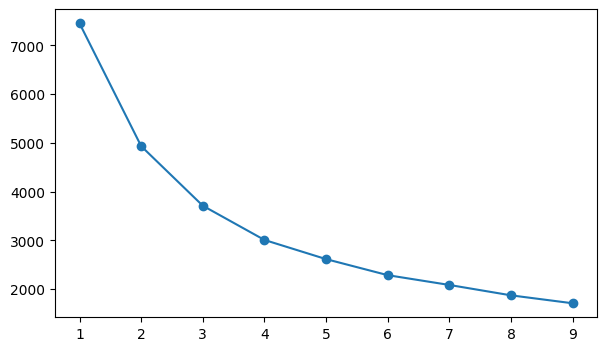

In [58]:
cluster_df = below_20

from sklearn.cluster import KMeans

lst =[]
for i in range(1, 10):
  km = KMeans(n_clusters = i, random_state = 1234)
  km.fit(cluster_df)
  lst.append(km.inertia_)

fig, ax = plt.subplots(1, figsize = (7,4))
plt.plot(range(1, 10), lst, marker = 'o')

In [60]:
import numpy as np
km3 = KMeans(n_clusters = 3, random_state = 1234)
km3.fit(cluster_df)
km3_pred = km3.fit_predict(cluster_df) + 1

np.unique(km3_pred)

array([1, 2, 3], dtype=int32)

<Axes: xlabel='PC1', ylabel='PC2'>

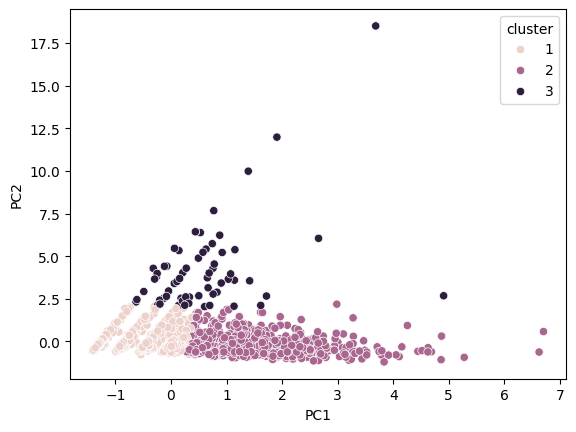

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_df = pd.DataFrame(pca.fit_transform(cluster_df) , columns = ['PC1', 'PC2'] )

pca_df['cluster'] = km3_pred
pca_df

sns.scatterplot(x = 'PC1', y= 'PC2', hue = 'cluster', data = pca_df)



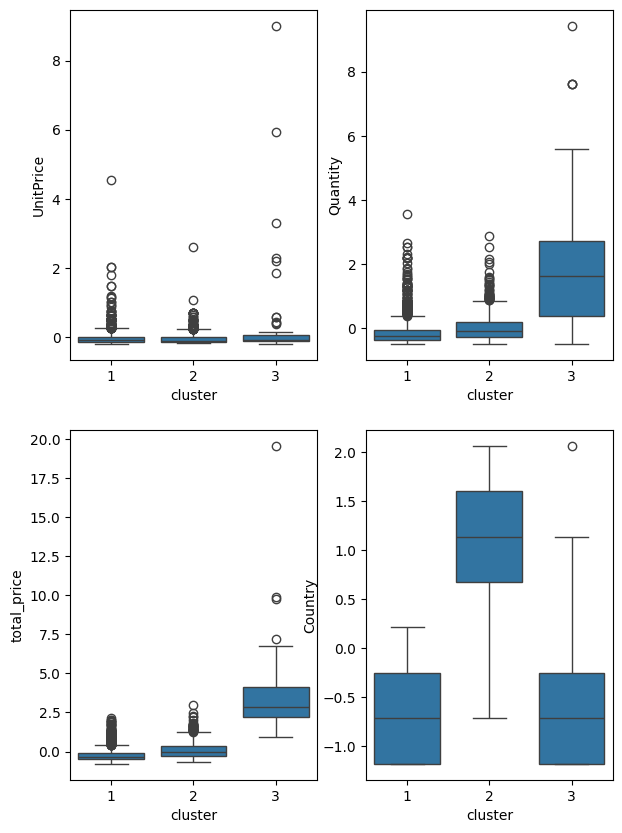

In [62]:
cluster_df['cluster'] = km3_pred

columns = list(cluster_df.columns)

fig, axes = plt.subplots(2,2 , figsize = (7,10))

for col_i , ax in zip(columns, axes.flat) :
    sns.boxplot(data = cluster_df[[col_i, 'cluster']], x = 'cluster', y = col_i, ax = ax)

각 군집 별 대표 추천 상품을 도출할 것

In [98]:
for i in range(4) :
  df = cluster_df[cluster_df[i]]
  product = c

cluster  StockCode
1        10120       -0.447567
         10125       -0.003523
         10133       -0.336556
         15034       -0.410563
         15039       -0.373560
                        ...   
3        84915       -0.447567
         84916       -0.447567
         84963A      -0.447567
         84968E      -0.373560
         85038       -0.447567
Name: CustomerID, Length: 2653, dtype: float64

In [100]:
cluster_df.groupby('cluster')['StockCode'].max()

KeyError: 'Column not found: StockCode'

In [136]:
best_df = cluster_df.reset_index().groupby(['cluster', 'StockCode'])['CustomerID'].max().reset_index().sort_values(by=['CustomerID'], ascending= False).\
drop_duplicates('cluster', keep ='first').reset_index(drop = True)

code = best_df['StockCode'].values

lst = []

for label, number  in cluster_df.reset_index().groupby(['cluster'])['CustomerID'].max().reset_index().values:

  best_prd_number =cluster_df[(cluster_df.cluster ==label) & (cluster_df.CustomerID ==number)].index[0]
  prd_name =df[df.StockCode == best_prd_number].Description.values[0]

print(f'{label} 의 stockcode {best_prd_number} 의 제품은 {prd_name}이며, 구매 횟수는 {number}')




3.0 의 stockcode 23084 의 제품은 RABBIT NIGHT LIGHT이며, 구매 횟수는 4.214889294562712


철강제품의 불량률을 조사하고자 한다. 이 때, 불량률의 90%, 추정오차한계가 5% 이내가 되기 위하여 적절한 표본의 크기 중 최소값은 얼마인가?

In [148]:
from scipy import stats
from sympy import *
import math

confa= 0.95

z_critial = stats.norm.ppf(1 - (1 - confa) / 2)
print(z_critial) # 1.64


p = 0.05

# n에 대한 방정식
n = Symbol('n')

d = z_critial * sqrt(p * (1-p)/n) - 0.05

print(solve(d)[0])




1.959963984540054
72.9877175931882


In [150]:
# Chat GPT
p = 0.9
e = 0.05 # 허용 오차 한계
z_critial = stats.norm.ppf(1 - (1 - confa) / 2)


n = (z_critial**2 * p * (1-p)) / (e ** 2)
print(n)

138.29251754498844


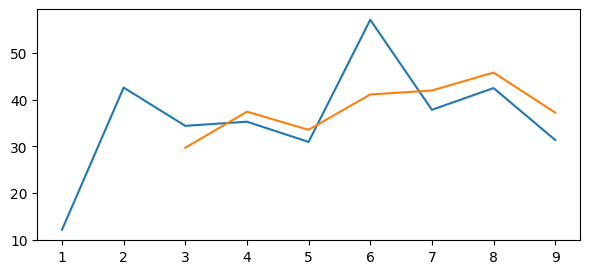

In [161]:
lst = [12.14,42.6,34.4,35.29,30.96,57.12,37.84,42.49,31.38]

df = pd.DataFrame(lst, columns = ['data'])

df.index = [str(i) for i in range(1,10)]
df['rolling_mean'] = df['data'].rolling(3).mean()

fig, ax = plt.subplots(1, figsize = (7,3))
plt.plot(df['data'])
plt.plot(df['rolling_mean'])

1 월 대비 9월의 은의 가격은 몇 % 올랐는가? 소수점 두번째 자리에서 반올림

In [168]:
(df.loc['9','data'] - df.loc['1','data']) / df.loc['1','data'] * 100

158.48434925864908

In [172]:
df = pd.DataFrame({"vote" :["찬성","반대"],
                    "A" : [176,124],
                    "B" : [193,107],
                    "C" : [159,141]})
df

# 교차포를 위한 index 설정
df.set_index('vote', inplace = True)
df


chi2, p, df, expected = chi2_contingency(df)
print(chi2, p)

7.945381231671554 0.01882272023214683


A초등학교 남학생 16명과 여학생 9명의 혈압을 측정한 pressure.csv파일을 가지고 남녀학생의 평균 혈압에 차이가 없는지 분석하라. 단, 남학생과 여학생의 혈압 데이터는 정규분포를 따르며 등분산임을 가정

In [174]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/pressure.csv')
df.head()

,gender,pressure
0,male,106.8
1,male,100.8
2,male,84.5
3,male,104.2
4,male,107.0


In [179]:
import scipy.stats as stats


male = df.loc[df.gender == 'male', 'pressure']
female = df.loc[df.gender == 'female', 'pressure']

## 남녀 평균 차이

t_res = stats.ttest_ind(male, female, equal_var = True)
t_res

TtestResult(statistic=1.598335024574904, pvalue=0.12361716364314851, df=23.0)

4-2에서 구한 검정 통계량 값을 바탕으로 신뢰구간

In [180]:
## 1. 평균 차이

diff = male.mean() - female.mean()

# 2. 자유도 계산
df = len(male) + len(female) - 2

# 3. 분산
m_var, f_var = male.var() , female.var()
m_n , f_n = len(male) , len(female)

# 4. 합동 분산
pe = ((m_n - 1) * m_var + (f_n -1) * f_var) / (m_n + f_n - 2)

# 5. 신뢰구간
conf_int = stats.t.interval(0.95,
                            df,
                            loc = diff,
                            scale = (pe * (1/m_n + 1 / f_n)) ** 0.5)

print(conf_int)

(-1.8560720920085423, 14.471349869786348)
